# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


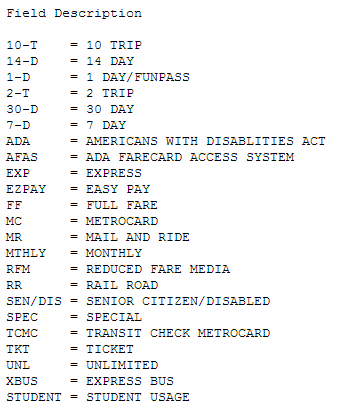

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from itertools import cycle
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

In [ ]:
# load in the data

In [2]:
mta = np.load('MTA_Fare.npy')

In [3]:
mta.shape

(600, 23, 194)

In [5]:
# to check
mta[mta<0].mean()

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [3]:
# first must creat it as a float
mta = mta.astype(np.float)
mta[mta < 0] = np.nan

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [7]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [ ]:
# just to understand what this thing looks like, let's make it into a dataframe

In [5]:
ridetype[:]

array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
       'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
       'umlim', 'xbus', 'stud'], dtype='<U5')

In [103]:
temp = pd.DataFrame.from_records(mta)

In [87]:
temp[0][0].shape

(194,)

In [104]:
temp.head()

0   \
0  [56961.0, 64703.0, 68002.0, 72628.0, 75866.0, ...   
1  [16210.0, 20179.0, 21769.0, 19307.0, 18076.0, ...   
2  [3292.0, 3429.0, 3629.0, 2808.0, 3614.0, 2601....   
3  [7774.0, 8158.0, 8405.0, 6839.0, 8581.0, 6572....   
4  [8794.0, 9388.0, 9437.0, 7799.0, 9836.0, 7259....   

                                                  1   \
0  [1732.0, 2083.0, 2107.0, 2188.0, 2314.0, 1921....   
1  [503.0, 647.0, 665.0, 582.0, 545.0, 390.0, 467...   
2  [110.0, 92.0, 102.0, 79.0, 93.0, 74.0, 72.0, 9...   
3  [257.0, 261.0, 249.0, 223.0, 235.0, 182.0, 208...   
4  [420.0, 450.0, 386.0, 316.0, 391.0, 284.0, 324...   

                                                  2   \
0  [203.0, 276.0, 245.0, 280.0, 265.0, 241.0, 278...   
1  [41.0, 43.0, 44.0, 39.0, 39.0, 31.0, 43.0, 43....   
2  [7.0, 6.0, 13.0, 7.0, 5.0, 7.0, 7.0, 6.0, 3.0,...   
3  [20.0, 28.0, 19.0, 20.0, 17.0, 17.0, 17.0, 16....   
4  [32.0, 27.0, 19.0, 31.0, 27.0, 13.0, 16.0, 11....   

                                                  3   \
0  [883.0, 958.0, 976.0, 987.0, 1012.0, 927.0, 89...   
1  [157.0, 165.0, 208.0, 180.0, 159.0, 137.0, 148...   
2  [41.0, 51.0, 47.0, 37.0, 50.0, 43.0, 44.0, 32....   
3  [125.0, 119.0, 112.0, 91.0, 116.0, 78.0, 95.0,...   
4  [142.0, 151.0, 154.0, 126.0, 125.0, 94.0, 111....   

                                                  4   \
0  [358.0, 529.0, 422.0, 261.0, 248.0, 362.0, 479...   
1  [29.0, 52.0, 40.0, 24.0, 31.0, 34.0, 45.0, 38....   
2  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...   
4  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...   

                                                  5   \
0  [17654.0, 20249.0, 20325.0, 20852.0, 20079.0, ...   
1  [3536.0, 4401.0, 4856.0, 4338.0, 4234.0, 3724....   
2  [1404.0, 1514.0, 1577.0, 1268.0, 1470.0, 1063....   
3  [2878.0, 3112.0, 3185.0, 2482.0, 3136.0, 2292....   
4  [2997.0, 3279.0, 3258.0, 2379.0, 3112.0, 2171....   

                                                  6   \
0  [32369.0, 42599.0, 41423.0, 42667.0, 42415.0, ...   
1  [11462.0, 14151.0, 14741.0, 13863.0, 12589.0, ...   
2  [1344.0, 1344.0, 1397.0, 1145.0, 1366.0, 1024....   
3  [4472.0, 4722.0, 4654.0, 3812.0, 4604.0, 3393....   
4  [5297.0, 5683.0, 5716.0, 4626.0, 5779.0, 4145....   

                                                  7   \
0  [59.0, 60.0, 67.0, 61.0, 51.0, 50.0, 58.0, 46....   
1  [8.0, 8.0, 10.0, 7.0, 12.0, 24.0, 9.0, 9.0, 6....   
2  [0.0, 1.0, 0.0, 5.0, 9.0, 0.0, 1.0, 1.0, 1.0, ...   
3  [1.0, 0.0, 0.0, 0.0, 4.0, 2.0, 6.0, 7.0, 3.0, ...   
4  [0.0, 2.0, 4.0, 1.0, 2.0, 0.0, 1.0, 3.0, 0.0, ...   

                                                  8   \
0  [6733.0, 5487.0, 6237.0, 7272.0, 7752.0, 9348....   
1  [451.0, 446.0, 549.0, 470.0, 473.0, 618.0, 471...   
2  [36.0, 14.0, 40.0, 23.0, 31.0, 21.0, 30.0, 33....   
3  [79.0, 44.0, 60.0, 41.0, 76.0, 46.0, 42.0, 53....   
4  [88.0, 64.0, 96.0, 40.0, 79.0, 55.0, 59.0, 43....   

                                                  9   \
0  [1835.0, 2320.0, 2521.0, 2759.0, 2673.0, 3561....   
1  [598.0, 829.0, 929.0, 737.0, 686.0, 610.0, 750...   
2  [174.0, 196.0, 196.0, 170.0, 179.0, 128.0, 116...   
3  [278.0, 282.0, 306.0, 234.0, 274.0, 176.0, 233...   
4  [353.0, 365.0, 346.0, 336.0, 386.0, 226.0, 274...   

                         ...                          \
0                        ...                           
1                        ...                           
2                        ...                           
3                        ...                           
4                        ...                           

                                                  13  \
0  [1035.0, 1359.0, 1263.0, 1269.0, 1170.0, 894.0...   
1  [90.0, 124.0, 133.0, 104.0, 89.0, 102.0, 107.0...   
2  [4.0, 6.0, 5.0, 4.0, 6.0, 4.0, 5.0, 6.0, 6.0, ...   
3  [9.0, 6.0, 6.0, 5.0, 4.0, 0.0, 0.0, 1.0, 0.0, ...   
4  [10.0, 6.0, 11.0, 11.0, 13.0, 7.0, 10.0, 8.0, ...   

      

In [9]:
mta.ndim

3

In [89]:
np.nansum(mta,axis=0).shape

(23, 194)

In [46]:
# let's practice to get the average for each station per ticket type
np.nanmean(mta[1],axis=1).shape

(23,)

Text(0,0.5,'Number of swipes')

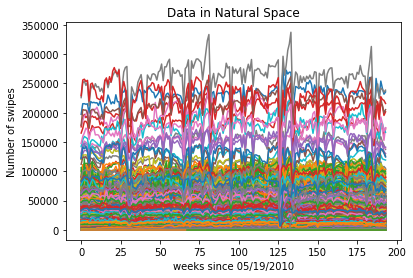

In [7]:
for i in range(len(mta)):
    for j in range(len(mta[0])):
        plt.plot(mta[i][j])
plt.title('Data in Natural Space')
plt.xlabel('weeks since 05/19/2010')
plt.ylabel('Number of swipes')

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Number of swipes (log10)')

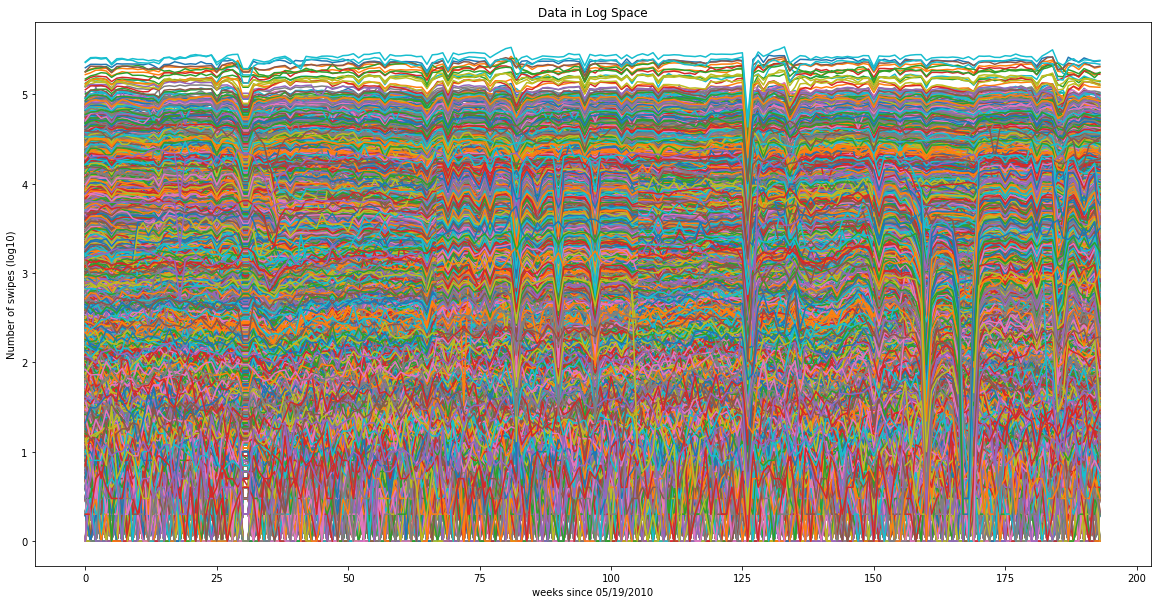

In [92]:
plt.figure(figsize=(20,10))
for i in range(len(mta[0])):
    plt.plot(np.log10(mta[:,i]).T) # Tanya showed me this, pretty clever of her to transpose - avoid double loop

plt.title('Data in Log Space')
plt.xlabel('weeks since 05/19/2010')
plt.ylabel('Number of swipes (log10)')

Here is a pretty cool looking graph of all mta rides per week. We see some patterns of shared movement between lines. Like a glass jar filled with colored sand that has been poked with a stick from above. A few points of steep changes are apparant. The most consistent looks to be the 125th week.

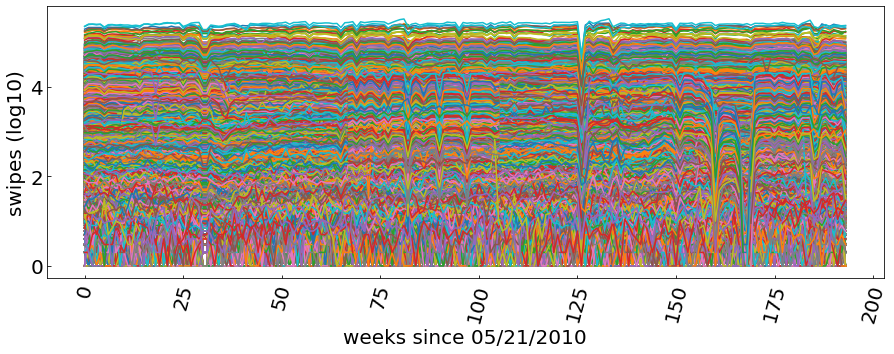

In [12]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)


#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



Create a date range (for example with pd.date_range())

In [4]:
# create date range 05/19/2010 to 02/19/2014
dates = pd.date_range(start = '19-05-2010', periods = 194, freq = 'W')

In [149]:
dates[194]

Timestamp('2014-02-09 00:00:00', freq='W-SUN')

The mean and stardand deviation of the time series can be used to set a 3-sigma threshold
every value that is more then 3 sigmas away from the mean can be flagged as an event

In [5]:
# sum all of the types...then take the average for all stations
all_type_sum = np.nanmean((np.nansum(mta, axis = 1)),axis = 0)

In [8]:
# For all stations
print("mean rides by usertype {:.2f}".format(np.nanmean(all_type_sum)))
print("stdev deaths by day {:.2f}".format(np.nanstd(all_type_sum)))
thresholds = [np.nanmean(all_type_sum) + 3 * np.nanstd(all_type_sum), 
              np.nanmean(all_type_sum) - 3 * np.nanstd(all_type_sum)]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean rides by usertype 49635.58
stdev deaths by day 4973.27
3-sigma thresholds 64555.39 34715.78


In [17]:
temp1 = pd.DataFrame(index = dates, data = all_type_sum, columns = ['avgRides'])

In [18]:
temp1.head()

avgRides
2010-05-23  44533.778333
2010-05-30  48776.618333
2010-06-06  49335.315000
2010-06-13  48979.320000
2010-06-20  48642.946667

Text(0.5,1,'Looking for the Outlier')

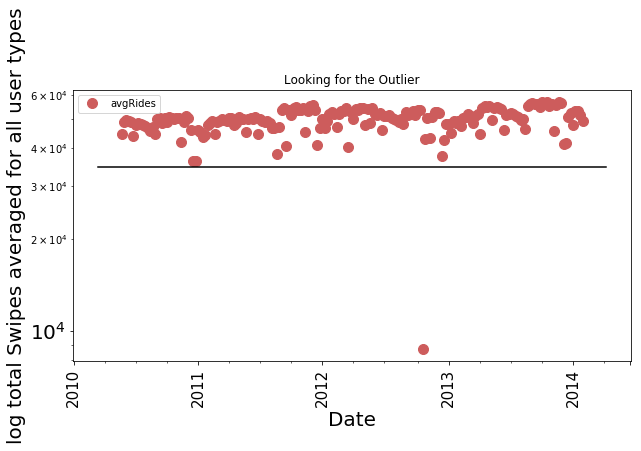

In [19]:
ax = temp1.plot(logy=True, figsize=(10,5), style=".", ms=20, color="IndianRed")
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k')
pl.xticks(rotation=90, fontsize=15)
pl.yticks(fontsize=20)
pl.ylabel("log total Swipes averaged for all user types", fontsize=20)
pl.xlabel("Date", fontsize=20);
pl.title('Looking for the Outlier')

We see an obvious outlier somewhere before 2013. Here is the plot of the averaged sum of rides throughout all rider types and stations. Each point represents the average number of rides in a week.

In [20]:
where(all_type_sum < thresholds[1])

(array([126]),)

Look up 127 weeks after 05/19/2010 in google. We see it is Wednesday October 24, 2012. We can also use the temporary dataframe I made to find the week.

In [21]:
temp1[temp1['avgRides']== 8697.81] # so what happened here?

avgRides
2012-10-21   8697.81

This is the week that Hurricane Sandy hit New York City. Makes sense people are not taking the subway this day.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [7]:
# take average over all stations for each usertype
ridetype

array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
       'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
       'umlim', 'xbus', 'stud'], dtype='<U5')

In [6]:
mtatype = np.nanmean(mta,axis=0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [23]:
mtatype.shape

(23, 194)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Number of swipes (log10)')

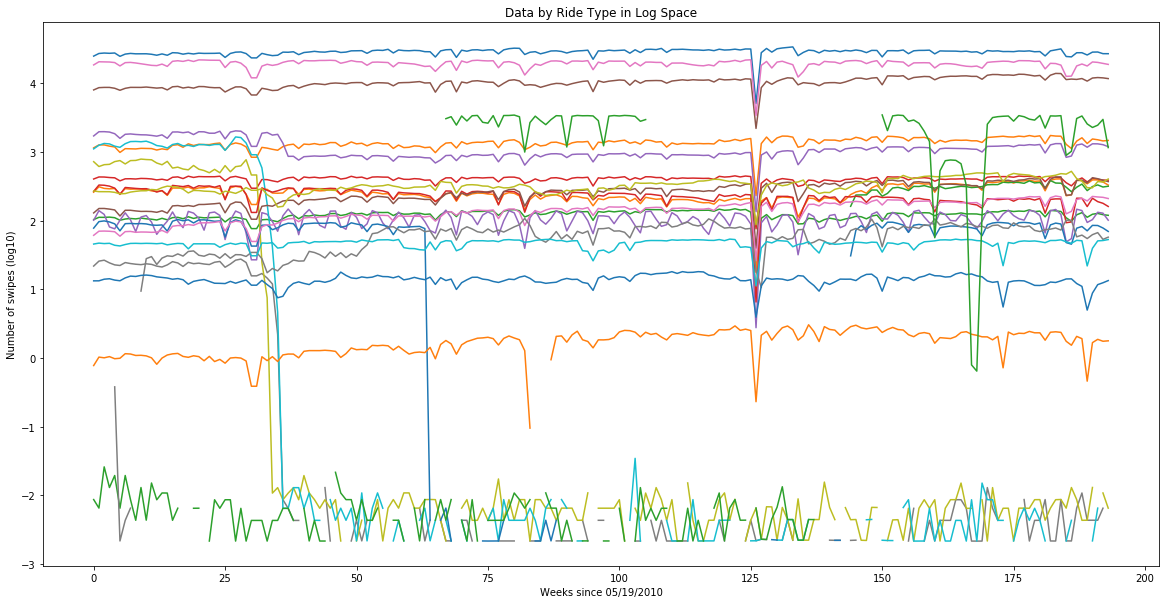

In [93]:
plt.figure(figsize=(20,10))
for i in range(len(mtatype)):
    plt.plot(np.log10(mtatype[i]).T)
plt.title('Data by Ride Type in Log Space')
plt.xlabel('Weeks since 05/19/2010')
plt.ylabel('Number of swipes (log10)')

In [7]:
#Angel did this part
for i in range(len(mtatype)):
    ratio=(np.nansum(mtatype[i][184:194])-np.nansum(mtatype[i][0:10]))/np.nansum(mtatype[i][0:10])
    std = np.nanstd(mtatype[i])
    print(i+1)
    print('stdev %.2f, fractional change over time: %.2f'%(std,ratio))


1
stdev 2659.34, fractional change over time: 0.02
2
stdev 199.86, fractional change over time: 0.25
3
stdev 16.16, fractional change over time: 0.11
4
stdev 37.13, fractional change over time: -0.06
5
stdev 27.27, fractional change over time: 0.04
6
stdev 1656.01, fractional change over time: 0.39
7
stdev 2273.81, fractional change over time: -0.10
8
stdev 8.76, fractional change over time: -1.00
9
stdev 239.21, fractional change over time: -1.00
10
stdev 477.35, fractional change over time: -1.00
11
stdev 42.44, fractional change over time: -0.18
12
stdev 63.64, fractional change over time: 0.22
13
stdev 136.67, fractional change over time: 24831.49
14
stdev 50.82, fractional change over time: -0.42
15
stdev 367.75, fractional change over time: -0.35
16
stdev 83.60, fractional change over time: 1.60
17
stdev 45.22, fractional change over time: 1.91
18
stdev 26.12, fractional change over time: 69.31
19
stdev 75.26, fractional change over time: 0.53
20
stdev 6.29, fractional change ove

In [57]:
# do a specific one for 23 because this card type doesn't have data
ratio=(np.nansum(mtatype[22][184:194])-np.nansum(mtatype[22][67:77]))/np.nansum(mtatype[22][67:77])
std = np.nanstd(mtatype[22])
print(22+1)
print('stdev %.2f, fractional change over time: %.2f'%(std,ratio))

23
stdev 1485.40, fractional change over time: -0.24


In [56]:
#where we first have data
mtatype[22][67:77]

array([3051.40130152, 3259.93506494, 2460.96095445, 3338.66666667,
       2825.02591793, 3365.91360691, 3400.69114471, 2702.95032397,
       2625.22198276, 3383.79049676])

## Sharpest Increase

We see that ridertype 13 has the greatest increase! Very much the greatest from the beginning of the time series to the end. Let's see what type of rider this is.

In [27]:
ridetype[13]

'month'

It is the monthly type of rider that had the steepest change. Perhaps this is due to this card type having the most value as prices have increased over the years. 

## Sharpest Decrease

8

stdev 8.76, fractional change over time: -1.00

9

stdev 239.21, fractional change over time: -1.00

10

stdev 477.35, fractional change over time: -1.00

This is interesting that they all have the same ratio in change from the beginning to the end. These are the ADA farecard access, express, and easy pay card types. 

In [ ]:
#adfullertest to reject these that are not to be observed

In [40]:
ridetype[7:10]

array(['afas', 'exp', 'ez'], dtype='<U5')

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Number of swipes (log10)')

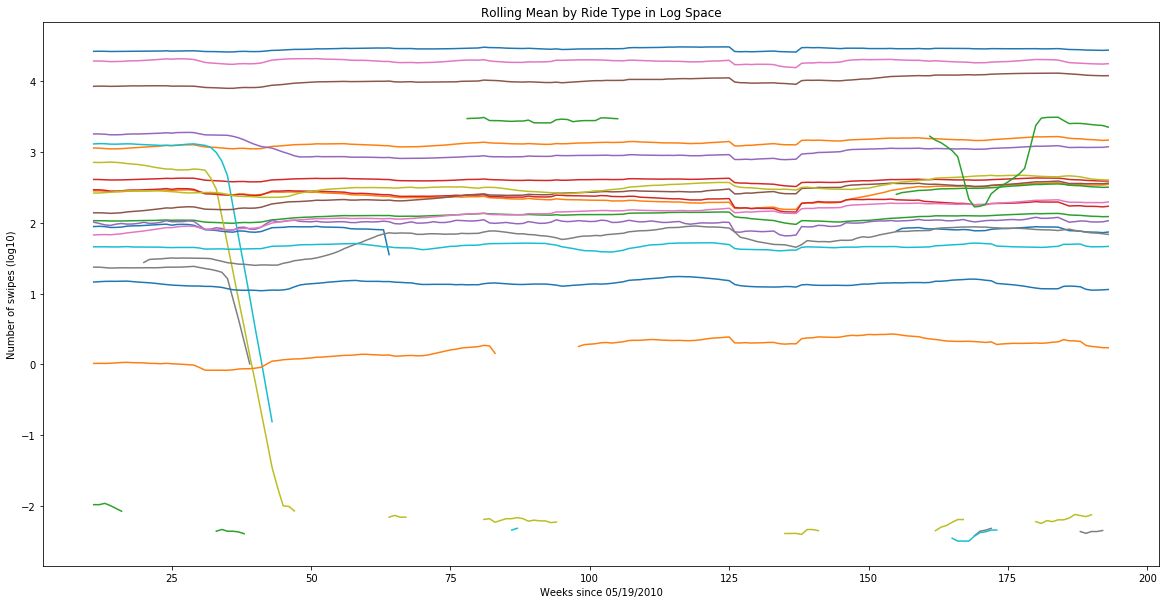

In [94]:
plt.figure(figsize=(20,10))
for i in range(len(mtatype)):
    plot(pd.rolling_mean(np.log10(mtatype[i]),12))
plt.title('Rolling Mean by Ride Type in Log Space')
plt.xlabel('Weeks since 05/19/2010')
plt.ylabel('Number of swipes (log10)')

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


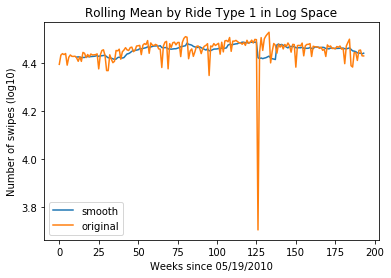

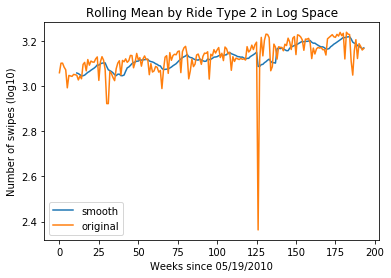

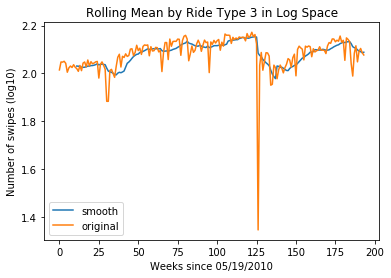

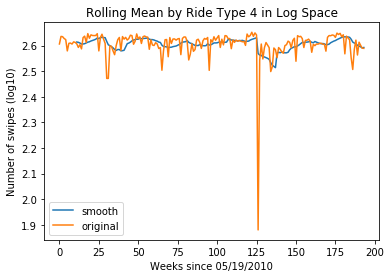

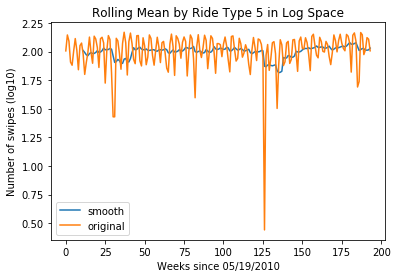

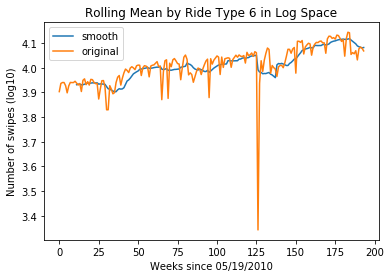

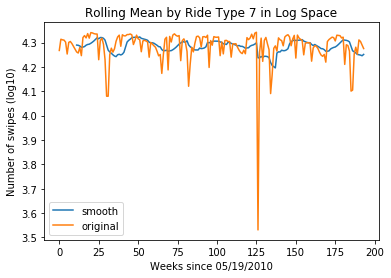

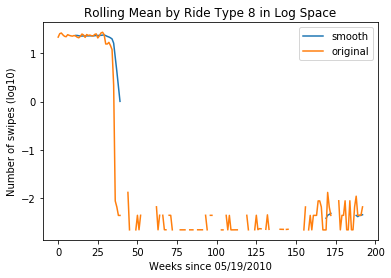

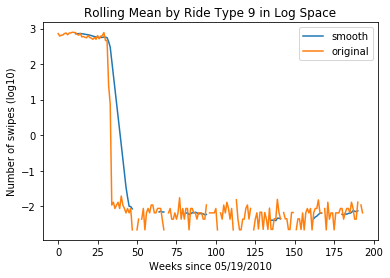

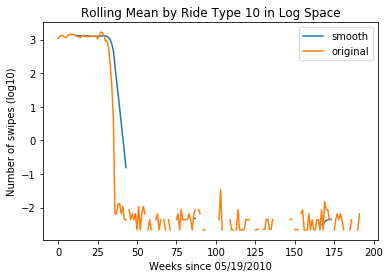

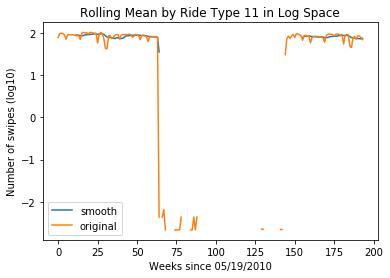

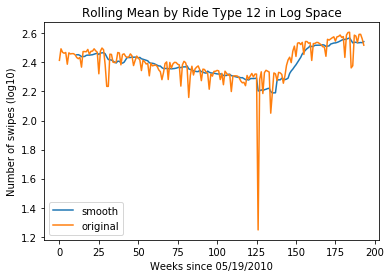

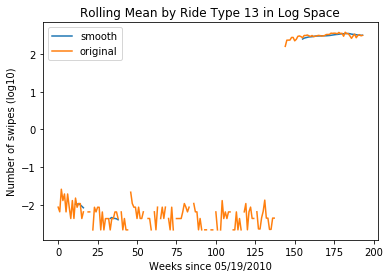

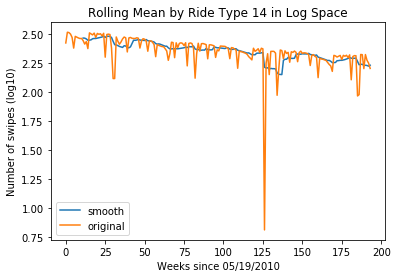

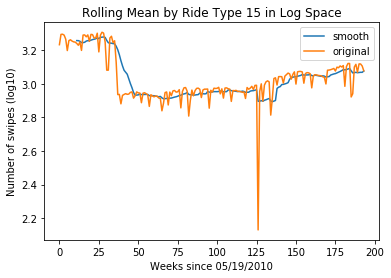

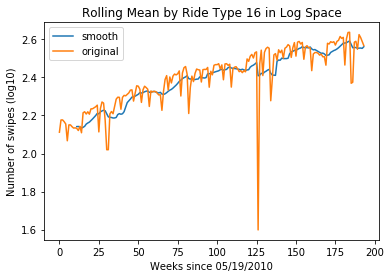

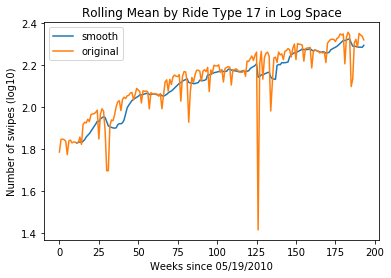

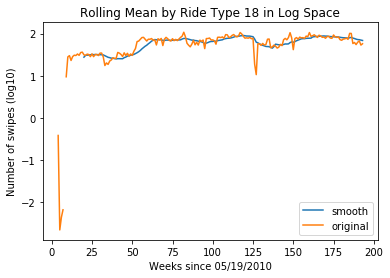

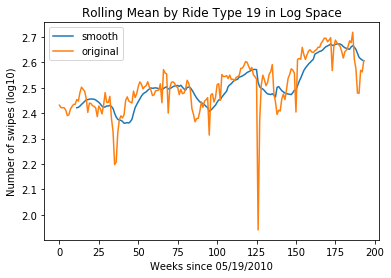

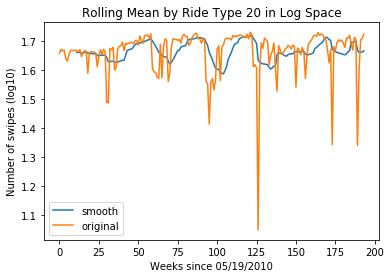

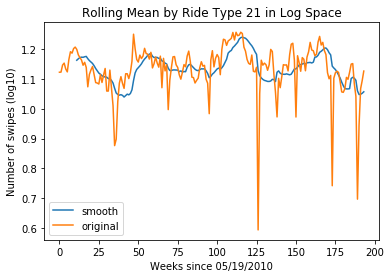

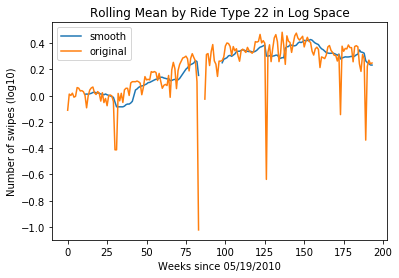

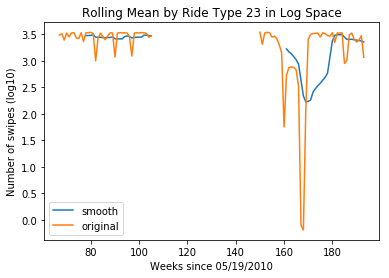

In [30]:
# plot each one separately
for i in range(len(mtatype)):
    plt.figure()
    plot(pd.rolling_mean(np.log10(mtatype[i]),12), label = 'smooth')
    plt.plot(np.log10(mtatype[i]),label = 'original')
    plt.title('Rolling Mean by Ride Type ' + str(i + 1) +' in Log Space')
    plt.xlabel('Weeks since 05/19/2010')
    plt.ylabel('Number of swipes (log10)')
    plt.legend()

Here we see each rider type plotted to see the comparable change ratio, the blue line represents the smooth trend line. Now it is apparant to see that type 13 had a significant increase. 

**! Look into decrease later

13
stdev 16498.07, fractional change over time 0.60: 
14
stdev 145035.47, fractional change over time 0.66: 


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


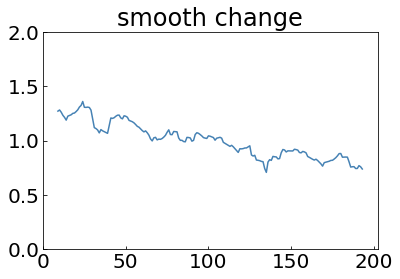

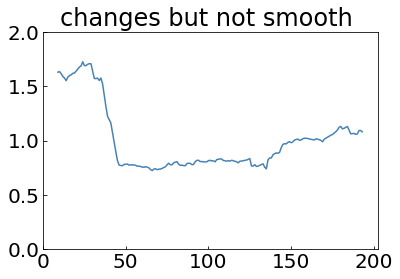

In [129]:
# examples of 2 time series with comparable change ratio, but only one of them has a smooth trend

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [ ]:
# convert mta from 3D to 2D - Rufei helped me with this 
#shape of original dataframe

In [220]:
#pd.DataFrame(mta.flatten()).dropna()

In [373]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [7]:
#reshape data so we can make it into dataframe
mta1 = mta.reshape(600*23,194)

In [8]:
mtadf = pd.DataFrame(mta1)

In [ ]:
# Then create label that repeats 0-22 for all of length

In [9]:
# use cycle to create label for each rider type
seq = cycle(range(23))
mtadf['label'] = [next(seq) for count in range(mtadf.shape[0])]

In [10]:
mtadf.set_index('label', drop=True, inplace =True)

In [11]:
mtadf = mtadf.dropna()

In [25]:
mtadf.shape

(9174, 194)

In [18]:
# normalize the data before standardized 

In [27]:
# take the mean of the whole dataset / station mean
normed_time_series_mean = nanmean(mta.flatten())/np.nanmean(mta,axis=1)
normed_time_series_std = nanstd(mta.flatten())/np.nanstd(mta,axis=1)

In [28]:
normed_time_series_std[:10]

array([[  0.86349798,   0.73330619,   0.71336816, ...,   1.36139795,
          1.45523706,   1.37071664],
       [  2.8715756 ,   2.3108341 ,   2.16778757, ...,          nan,
                 nan,          nan],
       [ 15.22864652,  14.6170992 ,  13.86721036, ...,  13.26784777,
         14.27102007,  15.55902799],
       ..., 
       [  8.91161761,   8.46968771,   8.27944121, ...,   7.51170225,
          7.66147665,   8.62446197],
       [  9.75724617,   9.24513491,   9.4742332 , ...,   8.32412352,
          8.52942218,   8.63088104],
       [  0.71364006,   0.67847737,   0.67409623, ...,   0.51919636,
          0.56524951,   0.5197497 ]])

In [26]:
#lets standardize
for i in range(len(mtadf)):
    mtadf.iloc[i] = (mtadf.iloc[i] - mtadf.iloc[i].mean()) / mtadf.iloc[i].std()

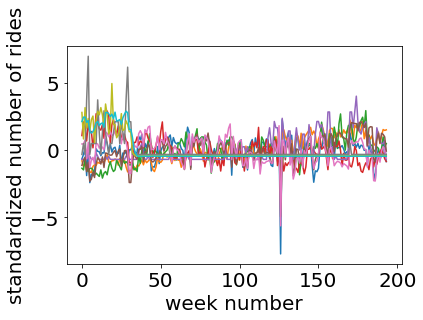

In [16]:
for i in range(10):
    pl.plot(mtadf.iloc[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

Now we see the number of rides standardized, they converge together and drop at the same point we found as that outlier. It is interesting to see the values get somewhat tighter between the weeks of 35-125

## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [24]:
#mtadf is everything without na
tsmean = np.nanmean(mtadf, axis=1)
tsmean.shape

(9174,)

In [29]:
tsmean[:10]

array([  3.54891753e+03,   1.44587629e+02,   1.79381443e+01,
         3.02577320e+01,   2.89690722e+00,   1.72666495e+03,
         1.25873711e+03,   3.86597938e-01,   4.62886598e+00,
         3.00618557e+01])

In [32]:
#mtadf is everything without na
tsstdev = np.nanstd(mtadf, axis=1)
tsstdev.shape

(9174,)

In [33]:
tsstdev[:10]

array([ 391.40042433,   43.60075488,    8.13711673,    9.80981872,
          4.23530701,  286.20893188,  182.35136007,    1.22685827,
         11.1163663 ,   67.14683317])

In [ ]:
# use the dataframe for this

In [34]:
mtadf.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
           dtype='int64', name=u'label', length=9174)

In [46]:
all_columns = "+".join(mtadf.columns)

TypeError: sequence item 0: expected string, int found

In [43]:
all_columns = "+".join(mtadf.columns - mtadf.index)

TypeError: cannot evaluate a numeric op <class 'pandas.indexes.numeric.Int64Index'> with type: <class 'pandas.indexes.base.Index'>

In [ ]:
(formula="A ~ B + C", data=df).fit()

In [39]:
allfits = sm.OLS(formula = 'mtadf.index ~ mtadf', data= mtadf).fit
[a.params[0] for a in allfits[:10]]

TypeError: __init__() takes at least 2 arguments (1 given)

### First Feature

In [397]:
# This is the array of each station's mean value, use this for the denominator
stationmeans = []
for i in range(len(mta)):
    mean = np.nanmean(mta[i])
    stationmeans.append(mean)
stationsmeans = asarray(stationmeans)
stationsmeans.shape

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


(600,)

In [ ]:
# now we need the mean for each type

In [406]:
stationmeans = []
for i in range(len(mta)):
    mean = np.nanmean(mta[i],axis=1)
    stationmeans.append(mean)
stationmeans

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


[array([5.85868854e+04, 1.82818229e+03, 2.37322917e+02, 7.37656250e+02,
        2.93140625e+02, 2.00333073e+04, 3.05572969e+04, 8.57291667e+00,
        9.77171875e+02, 4.31281250e+02, 2.39364583e+02, 7.50614583e+02,
        1.06140625e+02, 7.61854167e+02, 2.69753125e+03, 6.78062500e+02,
        1.87697917e+02, 0.00000000e+00, 5.96031250e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.40760000e+03]),
 array([1.67386126e+04, 4.93711712e+02, 4.05495495e+01, 1.48351351e+02,
        3.11891892e+01, 4.10724324e+03, 1.17095045e+04, 3.31531532e+00,
        1.16369369e+02, 2.11522523e+02, 3.56126126e+01, 2.81342342e+02,
        1.80180180e-02, 8.10270270e+01, 1.54071171e+03, 1.33432432e+02,
        7.54774775e+01, 0.00000000e+00, 1.11657658e+02, 0.00000000e+00,
        9.00900901e-03, 0.00000000e+00, 6.38772727e+02]),
 array([3.54891753e+03, 1.44587629e+02, 1.79381443e+01, 3.02577320e+01,
        2.89690722e+00, 1.72666495e+03, 1.25873711e+03, 3.86597938e-01,
        4.62886598e+

In [404]:
normed_time_series_mean = []
for i in range(len(mta)):
    mean_for_user_type = np.nansum(mta[i], axis=1)
mean_for_user_type
    #mean_for_user_type = mean_for_user_type/stationsmeans
    #normed_time_series_mean.append(mean_for_user_type)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [399]:
# This is the array of each station's mean value, use this for the denominator
stationstd = []
for i in range(len(mta)):
    std = np.nanstd(mta[i])
    stationstd.append(std)
stationstd = asarray(stationstd)
stationstd.shape

/usr/local/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(600,)

In [400]:
stationstd[:10]

array([14254.24093616,  4216.82526464,   825.23524006,  2094.5032992 ,
        2298.32714893,  2413.70267033,  1589.07255355,  1456.95784443,
        1269.94282159, 21804.20499175])

In [ ]:
# now we need to divide 
normed_time_series_mean = 

In [381]:
mta[0]/asarray(stationmeans)[0]

array([[10.69621645, 12.15002007, 12.76951092, ...,  6.85909128,
         6.3712352 ,  6.91486236],
       [ 0.32523739,  0.39114866,  0.39565541, ...,  0.23735569,
         0.2200798 ,  0.23247338],
       [ 0.03811962,  0.05182767,  0.04600644, ...,  0.03492734,
         0.03135949,  0.03135949],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ...,  0.21050295,
         0.25857499,  0.13370036]])

In [ ]:
# we can still use meansnan

In [281]:
np.nanmean(mta,axis=1)

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([[5767.18181818, 6794.40909091, 6926.5       , ..., 3430.47826087,
        3243.08695652, 3340.56521739],
       [1695.72727273, 2112.        , 2243.59090909, ...,           nan,
                  nan,           nan],
       [ 300.27272727,  312.77272727,  328.59090909, ...,  355.26086957,
         343.7826087 ,  295.2173913 ],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

In [285]:
stationsmeans = np.nanmean(mta,axis=1)
stationsmeans.shape[0]

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


600

In [286]:
stationsstd = np.nanstd(mta,axis=1)
stationsstd.shape[0]

/usr/local/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


600

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [318]:
normed_time_series_mean = nanmean(mta,axis=1)/ nanmean(np.nanmean(mta,axis=1))
normed_time_series_std = nanstd(mta,axis=1)/ nanstd(np.nanmean(mta,axis=1))

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/local/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [353]:
mta.shape

(600, 23, 194)

In [364]:
mtadf.apply(np.mean,axis=1)

46        3530.717949
47         143.851282
48          17.856410
49          30.117949
50           2.902564
51        1717.835897
52        1252.312821
53           0.420513
54           4.646154
55          29.953846
56           1.000000
57          17.353846
58          15.779487
59           8.266667
60          92.348718
61          12.364103
62           3.364103
63           0.087179
64          11.564103
65           0.097436
66           0.102564
67           0.107692
69        8707.087179
70         308.882051
71          26.410256
72         123.492308
73           1.210256
74        3617.323077
75        4095.030769
76           0.497436
             ...     
12549        0.071795
12550        0.076923
12551        0.082051
12552     2533.789744
12553      287.348718
12554        0.097436
12555        0.102564
12556        0.107692
12650    32796.282051
12651        0.774359
12652        0.158974
12653        0.317949
12654       14.810256
12655       17.107692
12656     

In [319]:
normed_time_series_std[:10]

array([[4.17804019, 4.91981289, 5.05731744, ..., 2.65001814, 2.47913509,
        2.63200223],
       [1.25635879, 1.56122383, 1.66424483, ...,        nan,        nan,
               nan],
       [0.23690413, 0.24681568, 0.26016258, ..., 0.27191518, 0.25280108,
        0.23187369],
       ...,
       [0.40483439, 0.42595777, 0.4357455 , ..., 0.48028118, 0.47089216,
        0.41831354],
       [0.36974872, 0.39023003, 0.3807938 , ..., 0.4334065 , 0.42297464,
        0.41800243],
       [5.05539064, 5.31739071, 5.3519499 , ..., 6.94867984, 6.38254287,
        6.94128207]])

In [56]:
tsmean = np.mean(mtadf, axis=1)
tsmean.shape

(9174,)

In [338]:
tsstdev = np.std(mtadf, axis=1)
tsstdev.shape

(9174,)

In [322]:
tsmean[:10]

array([3.53071795e+03, 1.43851282e+02, 1.78564103e+01, 3.01179487e+01,
       2.90256410e+00, 1.71783590e+03, 1.25231282e+03, 4.20512821e-01,
       4.64615385e+00, 2.99538462e+01])

In [326]:
tsstdev[:10]


array([465.47422461,  44.68182027,   8.19567725,   9.97645618,
         4.22516801, 310.83466418, 202.7021804 ,   1.31171829,
        11.09044047,  66.99133448])

In [53]:
allfits = sm.OLS('mtadf.index ~ 0',data = mtadf).fit()
[a.params[0] for a in allfits[:10]]

ValueError: unrecognized data structures: <type 'str'> / <type 'NoneType'>

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [291]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              np.mean(ts)/normedtsmean, np.std(ts)/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

NameError: name 'allfits' is not defined

In [100]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [80]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(1, 0, 0, 0)

In [101]:
X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

In [ ]:
#fit it on x_train x_test

In [105]:
clf = rfc()...

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

and use sklearn confusion_matrix to see the errors

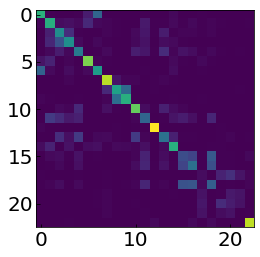

In [84]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    ...

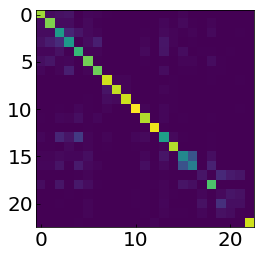

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   